<a href="https://colab.research.google.com/github/elliemci/vision-transformer-models/blob/main/image_segmentation/transformer_seg_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MRI image segmentation with SegFormer

Train a deep-learning-based semantic segmentation transformer model to identify the tumor locations and boundaries within MRI brain images, using brain images and coresponding ground truth masks. Pnce trained, SegFormer can predict bounderies of tumor regions. A segmentation accuracy metric Mean IoU is appliced to asses model quality.

In [ ]:
!pip install jedi

In [ ]:
!apt-get install libcairo2-dev pkg-config python3-dev

In [ ]:
!pip install pycairo

In [ ]:
!pip install --upgrade fsspec==2024.10.0

In [ ]:
!pip install datasets transformers

In [8]:
!pip install -q albumentations

In [9]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.8 MB/s eta 0:00:00


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
%cd /content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation

/content/drive/MyDrive/ColabNotebooks/ExplainableAI/image_segmentation


In [ ]:
!ls

data_preproces.ipynb  mri_data_seg  segmentation_dataset  transformer_seg_traiining.ipynb


## 1. Load MRI dataset

The dataset is a dictionary containg the images and coresponding masks, split into train, test and validate datasets.

In [ ]:
from datasets import load_from_disk

dataset = load_from_disk("segmentation_dataset")
dataset

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 400
    })
    test: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 200
    })
    validate: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 100
    })
})

In [ ]:
from datasets import load_dataset
from huggingface_hub import login

login(token=input("Enter Hugging Face token: "))

## 2. Training Function

### Load Hugging Face SegFormer model

In [ ]:
import torch
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# SegformerForSemanticSegmentation model is not competable with 2-class segmentation task
from transformers import SegformerForSemanticSegmentation
from transformers import AdamW, get_linear_schedule_with_warmup

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def list_and_set_gpu_memory_growth():
    """
    Lists available GPUs and sets memory growth for each GPU.
    """

    if torch.cuda.is_available():
        num_gpus = torch.cuda.device_count()
        print(f"Number of available GPUs: {num_gpus}")

        for i in range(num_gpus):
            gpu_properties = torch.cuda.get_device_properties(i)
            print(f"GPU {i}: {gpu_properties.name}")

            # Enable memory growth for this GPU
            torch.cuda.set_per_process_memory_fraction(1.0, device=i)
            #torch.cuda.empty_cache()

            # Check if memory growth is enabled (optional)
            #is_memory_growth_enabled = torch.cuda.is_memory_growth_enabled(i)  # PyTorch 2.0+
            #print(f"  Memory growth enabled: {is_memory_growth_enabled}")
    else:
        print("CUDA is not available.")

# Call the function to list and set memory growth
list_and_set_gpu_memory_growth()

# initialize the model
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
# load the SegformaerForSemanticSegmentation
model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels = 2,
    id2label = {0: 'background', 1: 'tumor'},
    label2id = {'background': 0, 'tumor': 1},
    ignore_mismatched_sizes = True
)

# set hyperparameters for training
batch_size = 2
num_epochs = 25
num_training_steps = (len(dataset['train'])//batch_size) * num_epochs
learning_rate = 6e-5
weight_decay_rate = 0.01

# compile the model
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=learning_rate,
                              weight_decay=weight_decay_rate)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = num_training_steps)

criterion = torch.nn.CrossEntropyLoss()

Number of available GPUs: 1
GPU 0: Tesla T4


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Set up training arguments for initializing hyperparameters

In [ ]:
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

batch_size = 2

# define a transform to convert PIL images to PyTorch tensors
transform = transforms.Compose([
    # convert PIL image to PyTorch tensor
    transforms.ToTensor(),  # convert PIL image to PyTorch tensor
])

def process_train_batch(batch):
  """ Read an bath of train images and transform them into inputs.
      Since transformer is pre-trained on RGB images convert from gray scale"""

  batch_imgs = [transform(img.convert("RGB")) for img in batch['pixel_values']]
  batch_masks = [transform(mask.convert("L")) for mask in batch['label']]

  # return a dictionary with image and label data
  return {'pixel_values': batch_imgs, 'mask': batch_masks}

def process_val_batch(batch):
  """ Read an bath of test images and transform them into inputs. """
  batch_imgs = [transform(img.convert("RGB")) for img in batch['pixel_values']]
  batch_masks = [transform(label.convert("L")) for label in batch['label']]

  # return a dictionary with image and label data
  return {'pixel_values': batch_imgs, 'mask': batch_masks}

dataset["train"].set_transform(process_train_batch)
dataset["test"].set_transform(process_train_batch)
dataset["validate"].set_transform(process_val_batch)

train_loader = DataLoader(dataset['train'], batch_size=batch_size, shuffle=True)
train_loader = DataLoader(dataset['test'], batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset['validate'], batch_size=batch_size, shuffle=True)


for batch in train_loader:
  # convert each gray scale image in batch to RGB

  print(f"batch data type: {type(batch)}")
  print(f"batch images size: {batch['pixel_values'].shape}")
  print(f"batch masks size: {batch['mask'].shape}")
  print()
  image = batch['pixel_values'][0]
  mask = batch['mask'][0]
  print(f"image dimensions: {image.size}")
  print(f"image data type: {image.dtype}")
  print(f"image min value: {image.min()}")
  print(f"image max value: {image.max()}")
  print(f"labels in mask:, {np.unique(mask)}")
  print(f"mask dimensions: {mask.size}")
  print(f"mask data type: {mask.dtype}")
  print(f"mask min value: {mask.min()}")
  print(f"mask max value: {mask.max()}")
  print()
  break

batch data type: <class 'dict'>
batch images size: torch.Size([2, 3, 512, 512])
batch masks size: torch.Size([2, 1, 512, 512])

image dimensions: <built-in method size of Tensor object at 0x7fe97806c890>
image data type: torch.float32
image min value: 0.0
image max value: 1.0
labels in mask:, [0. 1.]
mask dimensions: <built-in method size of Tensor object at 0x7fe97806ca10>
mask data type: torch.float32
mask min value: 0.0
mask max value: 1.0



## 3. Accuracy Estimation

In [ ]:
def calculate_iou(true_class, pred_class):
    """
    Calculate Intersection over Union (IoU) for a specific class.
    Args:
        true_class (torch.Tensor): Boolean mask for the true class.
        pred_class (torch.Tensor): Boolean mask for the predicted class.
    Returns:
        float: IoU score for the class.
    """

    intersection = torch.logical_and(true_class, pred_class)
    union = torch.logical_or(true_class, pred_class)

    if torch.any(union):
        iou = torch.sum(intersection).float() / torch.sum(union).float()
    else:
        iou = 0.0  # if no overlap
    #print(f"IoU: {iou}")
    #print()
    return iou


def calculate_mean_iou(true_mask, pred_mask):
    """
    Calculate the mean Intersection over Union (mIoU) score.
    Args:
        true_mask (torch.Tensor): Ground truth mask.
        pred_mask (torch.Tensor): Predicted mask.
    Returns:
        float: Mean IoU score across all classes.
    """

    #class_iou = []

    # Get the maximum class value (assuming contiguous classes starting from 0)
    #max_value = true_mask.max().item()
    #print(f"Max class value: {max_value}")

    #for i in range(1, max_value + 1):  # Skip background (class 0)
        #true_i = (true_mask == i)
        #pred_i = (pred_mask == i)
        #print(f"Class {i}: true_i sum: {torch.sum(true_i)}, pred_i sum: {torch.sum(pred_i)}")

        #iou = calculate_iou(true_i, pred_i)
        #print(f"Class {i} IoU: {iou}")
        #class_iou.append(iou)

    # Compute the mean IoU
    #if class_iou:
        #mean_iou = torch.mean(torch.tensor(class_iou))
    #else:
        #mean_iou = 0.0  # Handle case with no classes
        #print(f"Mean IoU: {mean_iou}")

    intersection = torch.logical_and(true_mask, pred_mask)
    union = torch.logical_or(true_mask, pred_mask)

    if torch.any(union):
        mean_iou = torch.sum(intersection).float() / torch.sum(union).float()
    else:
        mean_iou = 0.0  # if no overlap

    print(f"Mean IoU: {mean_iou}")

    return mean_iou


## 4. Callback Function

In [ ]:
def create_mask(pred_logits, target_size):
    """Create a mask from model logits."""

    # resize logits to match the ground truth size
    pred_logits_resized = F.interpolate(
        pred_logits,
        size=target_size,
        mode='bilinear',
        align_corners=False
    )

    class_0_logits = pred_logits_resized[:, 0, :, :]
    class_1_logits = pred_logits_resized[:, 1, :, :]

    print(f"Class 0 logits: mean={class_0_logits.mean()}, min={class_0_logits.min()}, max={class_0_logits.max()}")
    print(f"Class 1 logits: mean={class_1_logits.mean()}, min={class_1_logits.min()}, max={class_1_logits.max()}")


    #for i in range(pred_logits_resized.shape[1]):
      #print(f"Class {i} logits mean: {pred_logits[:, i, :, :].mean().item()}, max: {pred_logits[:, i, :, :].max().item()}")


    #plt.figure(figsize=(10, 5))
    #plt.subplot(1, 2, 1)
    #plt.imshow(class_0_logits[0].cpu().detach().numpy(), cmap="jet")
    #plt.title("Class 0 Logits")
    #plt.colorbar()

    #plt.subplot(1, 2, 2)
    #plt.imshow(class_1_logits[0].cpu().detach().numpy(), cmap="jet")
    #plt.title("Class 1 Logits")
    #plt.colorbar()

    #plt.show()

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # argmax zeros all pred_mask values
    print(f"predicted logits dims: {pred_logits_resized.shape}")
    pred_mask = torch.argmax(pred_logits_resized, dim=1)
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    print(f"Predicted mask: min={pred_mask.min()}, max={pred_mask.max()}")
    print(f"Predicted mask unique values: {torch.unique(pred_mask)}")

    return pred_mask

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image(image, ground_truth_mask, predicted_mask):
    """
    Display the input image, ground truth mask, and predicted mask side by side.

    Args:
        image (torch.Tensor): The input image tensor (C, H, W).
        ground_truth_mask (torch.Tensor): The ground truth mask tensor (H, W).
        predicted_mask (torch.Tensor): The predicted mask tensor (H, W).
    """
    # Move the image and masks to the CPU and convert to NumPy
    image = image.cpu().numpy().transpose(1, 2, 0)  # Convert (C, H, W) -> (H, W, C)
    ground_truth_mask = ground_truth_mask.cpu().numpy()

    ground_truth_mask = ground_truth_mask[0]

    # Select the first channel of the ground_truth_mask to display it as grayscale
    # ground_truth_mask = ground_truth_mask[0]
    #if predicted_mask is not None:

    predicted_mask = predicted_mask.cpu().numpy()

    # Normalize the image for display (optional: adjust depending on input range)
    image = (image - image.min()) / (image.max() - image.min())  # Normalize to [0, 1]

    # Create a figure with 3 subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(image)
    axs[0].set_title("Input Image")
    axs[0].axis("off")

    axs[1].imshow(ground_truth_mask, cmap="jet") # select the first channel
    axs[1].set_title("Ground Truth Mask")
    axs[1].axis("off")


    #if predicted_mask is not None:
    axs[2].imshow(predicted_mask, cmap="jet")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
@torch.no_grad()
def custom_callback(epoch, model, val_loader, device):
    """
    Callback function executed after each training epoch.
    Evaluates the model on the validation set and calculates mean IoU.
    """
    model.eval()
    print(f"Running validation for epoch {epoch + 1}...")

    total_mean_iou = 0.0
    num_batches = 0

    for batch in val_loader:
        pixel_values = batch['pixel_values'].to(device)
        true_mask = torch.argmax(batch['mask'].to(device), dim=1)

        # Get model predictions
        outputs = model(pixel_values)
        pred_mask = create_mask(outputs.logits, target_size=true_mask.shape[-2:])

        # Compute mean IoU for the batch
        mean_iou = calculate_mean_iou(true_mask, pred_mask)
        total_mean_iou += mean_iou
        num_batches += 1

    avg_mean_iou = total_mean_iou / num_batches
    print(f"Epoch {epoch + 1}: Mean IoU: {avg_mean_iou:.4f}")


    #print(f"Unique values in ground truth mask (batch): {torch.unique(batch['mask'])}")
    #print(f"Unique values in ground truth mask (per image): {torch.unique(true_mask[0])}")

    display_image(
        image=pixel_values[0],  # First image in the batch
        ground_truth_mask=true_mask[0],  # Ground truth mask for the first image
        predicted_mask=pred_mask[0]  # Predicted mask for the first image
      )


## 5. Run Training

In [1]:
import torch
import torch.nn.functional as F  # for the interpolate function

def train(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, custom_callback):
    """
    Trains the given model on the provided training data and displays predictions on validation data after each epoch.

    Args:
        model: The model to train.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        optimizer: Optimizer for updating model parameters.
        criterion: Loss function.
        num_epochs: Number of training epochs.
        device: Device to use for computation ('cuda' or 'cpu').
        custom_callback: Callback function to execute after each epoch.
    """
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0

        for batch in train_loader:
            # Move the pixel_values and label tensors to the device
            pixel_values = batch['pixel_values'].to(device)
            labels = torch.argmax(batch['mask'].to(device), dim=1).long()

            optimizer.zero_grad()
            outputs = model(pixel_values)

            # Resize model outputs to match the input image size
            outputs_resized = F.interpolate(
                outputs.logits,
                size=labels.shape[1:],  # match height and width of labels
                mode='bilinear',
                align_corners=False
            )

            # Compute the loss
            loss = criterion(outputs_resized, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_epoch_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_epoch_loss:.4f}")

        # Execute the custom callback function after each epoch
        #custom_callback(epoch, model, val_loader, device)


In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, num_epochs, device, custom_callback)

In [ ]:
# save model weigths
model.save_pretrained("segformer_tumor_segmentation")

# load trained model weigths
trained_model = SegformerForSemanticSegmentation.from_pretrained("segformer_tumor_segmentation")

In [ ]:
import torch
import torch.nn.functional as F

def evaluate_model(model, train_loader, device):
    """
    Evaluates the model on the training dataset and computes the Mean IoU.

    Args:
        model: The trained model.
        train_loader: DataLoader for the training data.
        device: Device to use for computation ('cuda' or 'cpu').

    Returns:
        float: The average Mean IoU score across the training dataset.
    """
    model.eval()  # Set the model to evaluation mode
    # Move the model to the specified device
    model.to(device)

    total_mean_iou = 0.0
    num_batches = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for batch in train_loader:
            pixel_values = batch['pixel_values'].to(device)
            true_mask = torch.argmax(batch['mask'].to(device), dim=1)  # Ground truth mask

            # Get model predictions
            outputs = model(pixel_values)
            pred_mask = create_mask(outputs.logits, target_size=true_mask.shape[-2:])  # Predicted mask

            # Compute mean IoU for the batch
            mean_iou = calculate_mean_iou(true_mask, pred_mask)
            total_mean_iou += mean_iou
            num_batches += 1

    avg_mean_iou = total_mean_iou / num_batches
    print(f"Training dataset: Mean IoU: {avg_mean_iou:.4f}")

    return avg_mean_iou

# After training the model:
train_mean_iou = evaluate_model(trained_model, train_loader, device)

In [ ]:
import matplotlib.pyplot as plt

def debug_visualize(image, true_mask, pred_mask):
    image = image.cpu().numpy().transpose(1, 2, 0)
    true_mask = true_mask.cpu().numpy()
    pred_mask = pred_mask.cpu().numpy()

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap="jet")
    plt.title("Ground Truth Mask")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap="jet")
    plt.title("Predicted Mask")
    plt.axis("off")

    plt.show()

In [ ]:
output = model(batch['pixel_values'].to(device))

pred_mask = create_mask(output.logits, target_size=batch['mask'].shape[-2:])

print(batch['pixel_values'][0].shape)
print(batch['mask'][0].shape)
print(pred_mask.shape)
display_image(
    image=batch['pixel_values'][0],
    ground_truth_mask=batch['mask'][0],
    predicted_mask=pred_mask[0]
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def display_image_and_mask(image, mask):
    """
    Displays an image and its corresponding mask.

    Args:
        image (torch.Tensor): The image tensor (C, H, W).
        mask (torch.Tensor): The mask tensor (H, W).
    """

    # Move tensors to CPU and convert to NumPy arrays
    image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    mask = mask.cpu().numpy()

    # Normalize the image for display
    image = (image - image.min()) / (image.max() - image.min())

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    # Display the mask
    axs[1].imshow(mask, cmap="jet")
    axs[1].set_title("True Mask")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

# Get a batch from the validation loader
for batch in val_loader:
    break  # Get only the first batch

# Access the image and mask from the batch
image = batch['pixel_values'][0]  # Get the first image from the batch
true_mask = batch['mask'][0].squeeze(0)  # Get the first mask and remove channel dimension if necessary


# Display the image and mask
display_image_and_mask(image, true_mask)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def display_image_and_masks(image, true_mask, predicted_mask):
    """
    Displays an image, its true mask, and the predicted mask.

    Args:
        image (torch.Tensor): The image tensor (C, H, W).
        true_mask (torch.Tensor): The true mask tensor (H, W).
        predicted_mask (torch.Tensor): The predicted mask tensor (H, W).
    """

    # Move tensors to CPU and convert to NumPy arrays
    image = image.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
    true_mask = true_mask.cpu().numpy()
    predicted_mask = predicted_mask.cpu().numpy()

    # Normalize the image for display
    image = (image - image.min()) / (image.max() - image.min())

    # Create a figure with three subplots
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    # Display the image
    axs[0].imshow(image)
    axs[0].set_title("Image")
    axs[0].axis("off")

    # Display the true mask
    axs[1].imshow(true_mask, cmap="jet")
    axs[1].set_title("True Mask")
    axs[1].axis("off")

    # Display the predicted mask
    axs[2].imshow(predicted_mask.squeeze(0), cmap="jet")
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    plt.tight_layout()
    plt.show()

# Get a batch from the validation loader
for batch in val_loader:
    break  # Get only the first batch

# Get the image and true mask from the batch
image = batch['pixel_values'][0].to(device)  # Move image to device
true_mask = batch['mask'][0].squeeze(0).to(device)  # Move mask to device and squeeze if necessary

# Get model prediction
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(image.unsqueeze(0))  # Add batch dimension for single image
    predicted_mask = torch.argmax(outputs.logits, dim=1)  # Get predicted mask

    # Resize predicted mask to match true mask dimensions - **Corrected**
    predicted_mask = torch.nn.functional.interpolate(
        predicted_mask.unsqueeze(1).float(),
        size=true_mask.shape[-2:],  # Use only the spatial dimensions (H, W)
        mode='nearest'
    ).squeeze(1).long()


# Display the image, true mask, and predicted mask
display_image_and_masks(image.cpu(), true_mask.cpu(), predicted_mask.cpu())

In [ ]:
print(image.shape)
print(true_mask.shape)
print(predicted_mask.shape)

In [ ]:
for batch in val_loader:
    break  # Get only the first batch

# Get the image and true mask from the batch
image = batch['pixel_values'][0].to(device)  # Move image to device
true_mask = batch['mask'][0].squeeze(0).to(device)  # Move mask to device and squeeze if necessary

# debug create_mask(pred_logits, target_size) by plotting the image, true_mask and predicted mask after call create_mask()
with torch.no_grad():  # Disable gradient calculation for inference
    outputs = model(image.unsqueeze(0))  # Add batch dimension for single image
    predicted_mask = create_mask(outputs.logits, target_size=true_mask.shape[-2:])  # Get predicted mask

display_image_and_masks(image.cpu(), true_mask.cpu(), predicted_mask.cpu())


## 6. Trainer Class with evaluation method

original image: (512, 512, 3)
original image pixel values: min=0.0, max=1.0
transformed image: torch.Size([3, 224, 224])
transformed image pixel values: min=0.0, max=0.976350540216086


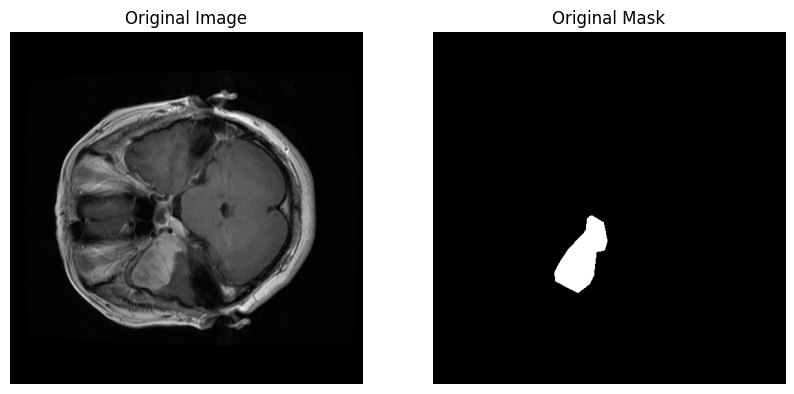

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b0-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
- decode_head.classifier.weight: found shape torch.Size([150, 256, 1, 1]) in the checkpoint and torch.Size([2, 256, 1, 1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:165: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)
  1%|          | 2/250 [00:00<00:54,  4.56it/s]

Loss: 0.3450946807861328


 41%|████      | 102/250 [00:12<00:22,  6.57it/s]

Loss: 0.2262122908441147


 81%|████████  | 203/250 [00:24<00:04, 10.47it/s]

Loss: 0.16509575052047842


100%|██████████| 250/250 [00:29<00:00,  8.51it/s]


Epoch 1, Loss: 0.1456


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/datasets/features/image.py:348: UserWarning: Downcasting array dtype int64 to int32 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
100%|██████████| 100/100 [00:11<00:00,  9.05it/s]
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/9e450724f21f05592bfb0255fe2fa576df8171fa060d11121d8aecfff0db80d0/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Epoch 1 Mean IoU: 0.36392665095764604


  1%|          | 2/250 [00:00<01:00,  4.11it/s]

Loss: 0.058282919228076935


 41%|████      | 102/250 [00:12<00:22,  6.73it/s]

Loss: 0.04796486901174678


 81%|████████  | 202/250 [00:24<00:04,  9.62it/s]

Loss: 0.041490638915875656


100%|██████████| 250/250 [00:31<00:00,  8.03it/s]


Epoch 2, Loss: 0.0388


100%|██████████| 100/100 [00:08<00:00, 12.19it/s]


Epoch 2 Mean IoU: 0.37421303848710047


  1%|          | 2/250 [00:00<01:21,  3.03it/s]

Loss: 0.02525586448609829


 40%|████      | 101/250 [00:12<00:15,  9.42it/s]

Loss: 0.023260112298597202


 80%|████████  | 201/250 [00:25<00:05,  9.53it/s]

Loss: 0.021153223228209943


100%|██████████| 250/250 [00:30<00:00,  8.26it/s]


Epoch 3, Loss: 0.0207


100%|██████████| 100/100 [00:09<00:00, 10.27it/s]


Epoch 3 Mean IoU: 0.3796467484341329


  1%|          | 2/250 [00:00<00:59,  4.14it/s]

Loss: 0.01510328333824873


 41%|████      | 102/250 [00:13<00:16,  9.14it/s]

Loss: 0.015067256673580349


 81%|████████  | 202/250 [00:25<00:05,  8.09it/s]

Loss: 0.014449562886683502


100%|██████████| 250/250 [00:31<00:00,  8.02it/s]


Epoch 4, Loss: 0.0139


100%|██████████| 100/100 [00:10<00:00,  9.91it/s]


Epoch 4 Mean IoU: 0.3760079954886915


  1%|          | 2/250 [00:00<00:59,  4.18it/s]

Loss: 0.010902738198637962


 41%|████      | 102/250 [00:12<00:23,  6.41it/s]

Loss: 0.011448085953546043


 81%|████████  | 202/250 [00:23<00:06,  7.04it/s]

Loss: 0.010447535492405666


100%|██████████| 250/250 [00:30<00:00,  8.13it/s]


Epoch 5, Loss: 0.0104


100%|██████████| 100/100 [00:08<00:00, 11.81it/s]


Epoch 5 Mean IoU: 0.39270034036211304


  1%|          | 2/250 [00:00<01:33,  2.65it/s]

Loss: 0.00721910921856761


 41%|████      | 102/250 [00:12<00:15,  9.51it/s]

Loss: 0.008536196170872685


 81%|████████  | 202/250 [00:25<00:05,  9.07it/s]

Loss: 0.008218324993417334


100%|██████████| 250/250 [00:33<00:00,  7.54it/s]


Epoch 6, Loss: 0.0082


100%|██████████| 100/100 [00:10<00:00,  9.63it/s]


Epoch 6 Mean IoU: 0.39362022435703786


  1%|          | 2/250 [00:00<01:29,  2.76it/s]

Loss: 0.008425680920481682


 41%|████      | 102/250 [00:12<00:15,  9.29it/s]

Loss: 0.007195627694894182


 81%|████████  | 202/250 [00:25<00:05,  9.12it/s]

Loss: 0.006886407137565797


100%|██████████| 250/250 [00:30<00:00,  8.20it/s]


Epoch 7, Loss: 0.0068


100%|██████████| 100/100 [00:09<00:00, 10.74it/s]


Epoch 7 Mean IoU: 0.42423015729160374


  1%|          | 2/250 [00:00<01:00,  4.12it/s]

Loss: 0.006493391003459692


 41%|████      | 102/250 [00:13<00:16,  9.22it/s]

Loss: 0.005879273156331169


 81%|████████  | 202/250 [00:25<00:05,  8.33it/s]

Loss: 0.00570343082321261


100%|██████████| 250/250 [00:31<00:00,  8.06it/s]


Epoch 8, Loss: 0.0056


100%|██████████| 100/100 [00:09<00:00, 10.02it/s]


Epoch 8 Mean IoU: 0.43352768211387027


  1%|          | 2/250 [00:00<00:58,  4.26it/s]

Loss: 0.003959124907851219


 41%|████      | 102/250 [00:12<00:23,  6.18it/s]

Loss: 0.004954998406793664


 81%|████████  | 202/250 [00:23<00:05,  9.43it/s]

Loss: 0.0048153526856290615


100%|██████████| 250/250 [00:30<00:00,  8.11it/s]


Epoch 9, Loss: 0.0048


100%|██████████| 100/100 [00:08<00:00, 12.40it/s]


Epoch 9 Mean IoU: 0.41968662517874045


  1%|          | 2/250 [00:00<01:28,  2.80it/s]

Loss: 0.003625839250162244


 41%|████      | 102/250 [00:12<00:15,  9.27it/s]

Loss: 0.0044367863672167655


 81%|████████  | 202/250 [00:25<00:05,  9.23it/s]

Loss: 0.004258029645920467


100%|██████████| 250/250 [00:30<00:00,  8.16it/s]


Epoch 10, Loss: 0.0043


100%|██████████| 100/100 [00:09<00:00, 10.80it/s]


Epoch 10 Mean IoU: 0.39119589954282724


  1%|          | 2/250 [00:00<00:59,  4.20it/s]

Loss: 0.004714768845587969


 41%|████      | 102/250 [00:13<00:16,  8.99it/s]

Loss: 0.004202303483547403


 81%|████████  | 202/250 [00:26<00:05,  9.17it/s]

Loss: 0.004143537777425045


100%|██████████| 250/250 [00:32<00:00,  7.61it/s]


Epoch 11, Loss: 0.0041


100%|██████████| 100/100 [00:10<00:00,  9.98it/s]


Epoch 11 Mean IoU: 0.4116281997059594


  1%|          | 2/250 [00:00<01:02,  3.96it/s]

Loss: 0.0027845429722219706


 41%|████      | 102/250 [00:13<00:15,  9.36it/s]

Loss: 0.0033100014206685936


 81%|████████  | 202/250 [00:25<00:07,  6.35it/s]

Loss: 0.003934766881200323


100%|██████████| 250/250 [00:31<00:00,  8.02it/s]


Epoch 12, Loss: 0.0038


100%|██████████| 100/100 [00:09<00:00, 10.42it/s]


Epoch 12 Mean IoU: 0.4161047670835599


  1%|          | 2/250 [00:00<00:57,  4.34it/s]

Loss: 0.00539341801777482


 41%|████      | 102/250 [00:12<00:22,  6.56it/s]

Loss: 0.0032120739699959167


 81%|████████  | 202/250 [00:23<00:05,  9.24it/s]

Loss: 0.003274363489932756


100%|██████████| 250/250 [00:30<00:00,  8.14it/s]


Epoch 13, Loss: 0.0033


100%|██████████| 100/100 [00:08<00:00, 11.80it/s]


Epoch 13 Mean IoU: 0.3965717076510986


  0%|          | 1/250 [00:00<03:05,  1.34it/s]

Loss: 0.002339377300813794


 41%|████      | 102/250 [00:13<00:16,  9.10it/s]

Loss: 0.002956416883210808


 81%|████████  | 202/250 [00:26<00:05,  8.62it/s]

Loss: 0.002919593375912909


100%|██████████| 250/250 [00:31<00:00,  7.86it/s]


Epoch 14, Loss: 0.0029


100%|██████████| 100/100 [00:10<00:00,  9.64it/s]


Epoch 14 Mean IoU: 0.43341187843634826


  1%|          | 2/250 [00:00<01:29,  2.78it/s]

Loss: 0.003363745054230094


 41%|████      | 102/250 [00:12<00:15,  9.30it/s]

Loss: 0.002843715605501196


 81%|████████  | 202/250 [00:25<00:05,  9.15it/s]

Loss: 0.0027474886830432792


100%|██████████| 250/250 [00:30<00:00,  8.14it/s]


Epoch 15, Loss: 0.0027


100%|██████████| 100/100 [00:09<00:00, 10.76it/s]


Epoch 15 Mean IoU: 0.41677240045918673


  1%|          | 2/250 [00:00<01:01,  4.02it/s]

Loss: 0.002165228594094515


 41%|████      | 102/250 [00:14<00:15,  9.37it/s]

Loss: 0.0024746066480321755


 81%|████████  | 202/250 [00:28<00:07,  6.56it/s]

Loss: 0.002407643410020429


100%|██████████| 250/250 [00:35<00:00,  6.97it/s]


Epoch 16, Loss: 0.0024


100%|██████████| 100/100 [00:08<00:00, 11.99it/s]


Epoch 16 Mean IoU: 0.4039332970817473


  1%|          | 2/250 [00:00<00:57,  4.33it/s]

Loss: 0.0028115776367485523


 41%|████      | 102/250 [00:13<00:16,  8.93it/s]

Loss: 0.0023786247578809166


 81%|████████  | 202/250 [00:25<00:05,  9.31it/s]

Loss: 0.0023285195588213


100%|██████████| 250/250 [00:30<00:00,  8.15it/s]


Epoch 17, Loss: 0.0023


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


Epoch 17 Mean IoU: 0.42238132640525244


  1%|          | 2/250 [00:00<01:00,  4.09it/s]

Loss: 0.002675913041457534


 41%|████      | 102/250 [00:13<00:15,  9.41it/s]

Loss: 0.002270819887283747


 81%|████████  | 202/250 [00:29<00:06,  7.90it/s]

Loss: 0.002235853924376621


100%|██████████| 250/250 [00:34<00:00,  7.15it/s]


Epoch 18, Loss: 0.0022


100%|██████████| 100/100 [00:10<00:00,  9.84it/s]


Epoch 18 Mean IoU: 0.4253615088715687


  1%|          | 2/250 [00:00<00:57,  4.28it/s]

Loss: 0.0017028216971084476


 41%|████      | 102/250 [00:12<00:22,  6.52it/s]

Loss: 0.0019096001541232782


 81%|████████  | 202/250 [00:23<00:05,  8.72it/s]

Loss: 0.002068017482576864


100%|██████████| 250/250 [00:31<00:00,  8.00it/s]


Epoch 19, Loss: 0.0020


100%|██████████| 100/100 [00:12<00:00,  8.24it/s]


Epoch 19 Mean IoU: 0.41867711920729866


  1%|          | 2/250 [00:00<00:57,  4.28it/s]

Loss: 0.0018112593097612262


 40%|████      | 101/250 [00:15<00:39,  3.76it/s]

Loss: 0.002011679338249793


 81%|████████  | 202/250 [00:28<00:06,  6.90it/s]

Loss: 0.002056810745983315


100%|██████████| 250/250 [00:34<00:00,  7.19it/s]


Epoch 20, Loss: 0.0021


100%|██████████| 100/100 [00:10<00:00,  9.26it/s]


Epoch 20 Mean IoU: 0.4075856443719413


In [23]:
import os
import glob
import cv2
import torch
import numpy as np
import albumentations as A
import evaluate
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from matplotlib import pyplot as plt
from datasets import load_dataset
from huggingface_hub import login
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation



dataset = load_dataset("akar49/MRI_Segmentation-1")

train = dataset["train"]
test = dataset["validation"]

class CustomDataset(Dataset):
    def __init__(self, dataset, transform=None):
        """ Constructor for the image segmentation dataset, a lit of image and mask pairs. """
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
      """ Gets length of dataset. """
      return len(self.dataset)

    def __getitem__(self, idx):
      """ For a given dataset index extract image and mask, convert image to RGB,
          since model is trained on RGB images, normalize pixel values to [0, 1],
          and apply transformation. """

      image = self.dataset[idx]['image']
      mask  = self.dataset[idx]['label']

      org_image = np.stack((image,) * 3, axis=-1)

      mask = np.array(mask)

      transformed = self.transform(image=org_image, mask=mask)
      trans_image = transformed['image']
      trans_mask = transformed['mask']
      org_image = org_image/255.0
      org_mask  = mask/255.0
      transformed = self.transform(image=org_image, mask=org_mask)
      trans_image = transformed['image']
      trans_mask = transformed['mask']

      # Convert trans_image to a PyTorch tensor
      trans_image = torch.from_numpy(trans_image).permute(2, 0, 1) # permute to (C, H, W)
      return trans_image, trans_mask, org_image, org_mask


transform = A.Compose([A.Resize(width=224, height=224)])
custom_dataset = CustomDataset(train, transform=transform)
trans_image, trans_mask, org_image, org_mask = custom_dataset[0]

print(f"original image: {org_image.shape}")
print(f"original image pixel values: min={org_image.min()}, max={org_image.max()}")
print(f"transformed image: {trans_image.shape}")
print(f"transformed image pixel values: min={trans_image.min()}, max={trans_image.max()}")

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.axis("off")
plt.imshow(org_image)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(org_mask, cmap='gray')
plt.axis("off")
plt.title("Original Mask")
plt.show()

transform = A.Compose([A.Resize(width=224, height=224)])

train_dataset = CustomDataset(train, transform=transform)
test_dataset = CustomDataset(test, transform=transform)

id2label = {0:  'bg',
            1:  'tumor'}
label2id = { label: id for id, label in id2label.items() }
n_classes = len(id2label)


image_processor = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
image_processor.ignore_index = 255
image_processor.reduce_labels = False
image_processor.do_resize = False
image_processor.do_rescale = False
image_processor.do_normalize = False

def collate_func(batch):

    """ Custom collate function for DataLoader, for an input batch list of samples,
    each containing transformed image, segmentation mask, original image, and
    original segmentation mask, returning a dictionary containing processed batch data. """

    inputs = list(zip(*batch))

    images = inputs[0]
    masks = inputs[1]

    # convert images to a PyTorch tensor
    pixel_values = torch.stack(images)

    # create a batch dictionary
    batch = {
        "pixel_values": pixel_values, # Use 'pixel_values' as the key
        "mask_labels": masks,  # or another appropriate key if needed
    }


    batch["org_images"] = inputs[2]
    batch["org_mask"] = inputs[3]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, collate_fn=collate_func, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=2, collate_fn=collate_func, shuffle=False, num_workers=2)


id2label = {0:  'bg',
            1:  'tumor'}
label2id = { label: id for id, label in id2label.items() }
n_classes = len(id2label)
class_labels = ['bg', 'tumor']

metric = evaluate.load("mean_iou")

# initialize the model
model_checkpoint = "nvidia/segformer-b0-finetuned-ade-512-512"
# load the SegformaerForSemanticSegmentation
model = SegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels = 2,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes = True
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = optim.AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

running_loss = 0.0
num_samples = 0
num_epochs = 20

class Trainer:

    def __init__(self, model, train_dataloader, test_dataloader, optimizer, device, image_processor, id2label, metric):
        self.model = model
        self.train_dataloader = train_dataloader
        self.test_dataloader = test_dataloader
        self.optimizer = optimizer
        self.device = device
        self.image_processor = image_processor
        self.id2label = id2label
        self.metric = metric
        self.feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")



    def train_one_epoch(self, epoch):
        """Trains the model for one epoch and returns the average training loss."""
        self.model.train()
        running_loss = 0.0
        num_samples = 0

        for idx, batch in enumerate(tqdm(self.train_dataloader)):
            self.optimizer.zero_grad()

            pixel_values = batch["pixel_values"].to(self.device, dtype=torch.float32)

            outputs = self.model(pixel_values=pixel_values)

            # Resize true_masks to match the output size before flattening
            true_masks = torch.tensor(batch['mask_labels']).to(self.device)
            true_masks = torch.nn.functional.interpolate(
                true_masks.unsqueeze(1).float(),
                size=outputs.logits.shape[-2:],  # match the output's spatial dimensions
                mode='nearest'
            ).squeeze(1).long()
            # flatten for CrossEntropyLoss
            true_masks = true_masks.reshape(pixel_values.shape[0], -1)
            predictions = outputs.logits.reshape(pixel_values.shape[0], model.config.num_labels, -1)

            loss = criterion(predictions, true_masks)

            loss.backward()

            batch_size = batch["pixel_values"].size(0)
            running_loss += loss.item()
            num_samples += batch_size

            if idx % 100 == 0:
                print("Loss:", running_loss / num_samples)

            self.optimizer.step()

        epoch_loss = running_loss / num_samples
        print(f"Epoch {epoch + 1}, Loss: {epoch_loss:.4f}")
        return epoch_loss

    def evaluate(self, epoch):
        """Evaluates the model on the test dataset and returns the mean IoU."""
        self.model.eval()

        self.metric = evaluate.load("mean_iou")
        with torch.no_grad():
            for idx, batch in enumerate(tqdm(self.test_dataloader)):
                pixel_values = batch["pixel_values"].to(self.device, dtype=torch.float32)

                outputs = self.model(pixel_values=pixel_values)

                original_images = batch["org_images"]
                target_sizes = [(image.shape[0], image.shape[1]) for image in original_images]

                predicted_segmentation_maps = self.feature_extractor.post_process_semantic_segmentation(
                      outputs, target_sizes=target_sizes
                      )

                ground_truth_segmentation_maps = batch["org_mask"]

                self.metric.add_batch(
                    references=ground_truth_segmentation_maps,
                    predictions=predicted_segmentation_maps
                )

        mean_iou = self.metric.compute(num_labels=len(self.id2label), ignore_index=0)["mean_iou"]
        print(f"Epoch {epoch + 1} Mean IoU: {mean_iou}")
        return mean_iou

    def train(self, num_epochs):
        """Trains the model for the specified number of epochs."""
        for epoch in range(num_epochs):
            train_loss = self.train_one_epoch(epoch)
            mean_iou = self.evaluate(epoch)

trainer = Trainer(model, train_dataloader, test_dataloader, optimizer, device, image_processor, id2label, metric)
trainer.train(num_epochs=num_epochs)


In [24]:
# save trained model weigths
model.save_pretrained("segformer_tumor_segmentation")

# load trained model weigths
trained_model = SegformerForSemanticSegmentation.from_pretrained("segformer_tumor_segmentation")